In [2]:
male_dir = "/kaggle/input/gender-recognition-by-voiceoriginal/data/male"
female_dir = '/kaggle/input/gender-recognition-by-voiceoriginal/data/female'

In [3]:
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset,DataLoader
from torchsummary import summary
import torchaudio
import torchaudio.transforms as transforms
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
X_train,X_val,y_train,y_val = [],[],[],[]
audios = os.listdir(male_dir)
audio_male = [os.path.join(male_dir,f) for f in audios if f.endswith(('.wav'))]
label = [0]*len(audio_male)
X_train_m,X_val_m,y_train_m,y_val_m = train_test_split(audio_male,label,test_size = 0.2,shuffle=True)
audios = os.listdir(female_dir)
audio_female = [os.path.join(female_dir,f) for f in audios if f.endswith(('.wav'))]
label = [1]*len(audio_female)
X_train_f,X_val_f,y_train_f,y_val_f = train_test_split(audio_female,label,test_size = 0.2,shuffle=True)
X_train += X_train_m
X_train += X_train_f
X_val += X_val_m
X_val += X_val_f
y_train += y_train_m
y_train += y_train_f
y_val += y_val_m
y_val += y_val_f
train_idx = list(range(len(X_train)))
val_idx = list(range(len(X_val)))
random.shuffle(train_idx)
random.shuffle(val_idx)
X_train = np.array(X_train)[train_idx]
X_val = np.array(X_val)[val_idx]
y_train = np.array(y_train)[train_idx]
y_val = np.array(y_val)[val_idx]
train_data = {
    'audio_path':X_train,
    'label':y_train
}
val_data = {
    'audio_path':X_val,
    'label':y_val
}
train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)

In [6]:
print(train_df.iloc[:20])
print(val_df.iloc[:20])

                                           audio_path  label
0   /kaggle/input/gender-recognition-by-voiceorigi...      0
1   /kaggle/input/gender-recognition-by-voiceorigi...      0
2   /kaggle/input/gender-recognition-by-voiceorigi...      1
3   /kaggle/input/gender-recognition-by-voiceorigi...      0
4   /kaggle/input/gender-recognition-by-voiceorigi...      1
5   /kaggle/input/gender-recognition-by-voiceorigi...      0
6   /kaggle/input/gender-recognition-by-voiceorigi...      0
7   /kaggle/input/gender-recognition-by-voiceorigi...      0
8   /kaggle/input/gender-recognition-by-voiceorigi...      1
9   /kaggle/input/gender-recognition-by-voiceorigi...      0
10  /kaggle/input/gender-recognition-by-voiceorigi...      0
11  /kaggle/input/gender-recognition-by-voiceorigi...      1
12  /kaggle/input/gender-recognition-by-voiceorigi...      0
13  /kaggle/input/gender-recognition-by-voiceorigi...      1
14  /kaggle/input/gender-recognition-by-voiceorigi...      1
15  /kaggle/input/gender

In [7]:
SR = 16000
LR = 0.0001
EPOCHS = 10
BATCH_SIZE = 8
AUD_LENGTH = 30*SR

In [8]:
mel_spectrogram = transforms.MelSpectrogram(
    sample_rate=SR,
    n_fft = 1024,
    hop_length = 512,
    n_mels = 64
)

In [9]:
def audio_preprocessing(signal,sr,transform,device):
    # handle channels
    if signal.shape[0] != 1:
        signal = torch.mean(signal,axis=0,keepdims=True)
    # handling sample rate
    if sr != SR:
        resampler = transforms.Resample(sr,SR).to(device)
        signal = resampler(signal)
    # handling size
    # longer
    if signal.shape[1] > AUD_LENGTH:
        signal = signal[:,:AUD_LENGTH]
    # shorter
    if signal.shape[1] < AUD_LENGTH:
        signal_lgth = signal.shape[1]
        pad_lgth = AUD_LENGTH-signal_lgth
        signal = nn.functional.pad(signal,(0,pad_lgth))
    if transform:
        transform.to(device)
        signal = transform(signal)
    signal = signal.to(device)
    return signal

In [10]:
class AudioDataset(Dataset):
    def __init__(self,df,transform=None):
        self.df = df
        self.transform = transform
        self.labels = torch.tensor(df['label'],dtype=torch.float32)
    def __len__(self):
        return self.labels.shape[0]
    def __getitem__(self,idx):
        label = round(self.labels[idx].item())
        audio_pth = self.df['audio_path'].iloc[idx]
        signal,sr = torchaudio.load(audio_pth)
        signal = signal.to(device)
        signal = audio_preprocessing(signal,sr,self.transform,device)
        return signal,label
    

In [11]:
train_dataset = AudioDataset(train_df,mel_spectrogram)
val_dataset = AudioDataset(val_df,mel_spectrogram)

In [12]:
train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=True)

In [26]:
class AudioCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1,16,kernel_size=3,stride=1,padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.5)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32,kernel_size=3,stride=1,padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.5)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64,kernel_size=3,stride=1,padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.5)
        )
        self.autopool = nn.AdaptiveAvgPool2d((7,7))
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(7*7*64,128)
        self.logit = nn.Linear(128,1)
    def forward(self,x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.autopool(x)
        x = self.flatten(x)
        x = self.linear(x)
        x = self.logit(x)
        return x
        

In [28]:
model = AudioCNN().to(device)
summary(model,input_size=(1,64,938))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 66, 940]             160
       BatchNorm2d-2          [-1, 16, 66, 940]              32
              ReLU-3          [-1, 16, 66, 940]               0
         MaxPool2d-4          [-1, 16, 33, 470]               0
           Dropout-5          [-1, 16, 33, 470]               0
            Conv2d-6          [-1, 32, 35, 472]           4,640
       BatchNorm2d-7          [-1, 32, 35, 472]              64
              ReLU-8          [-1, 32, 35, 472]               0
         MaxPool2d-9          [-1, 32, 17, 236]               0
          Dropout-10          [-1, 32, 17, 236]               0
           Conv2d-11          [-1, 64, 19, 238]          18,496
      BatchNorm2d-12          [-1, 64, 19, 238]             128
             ReLU-13          [-1, 64, 19, 238]               0
        MaxPool2d-14           [-1, 64,

In [29]:
criterion = nn.BCEWithLogitsLoss().to(device)
optimiser = Adam(model.parameters(),lr=LR)

## Training Loop

In [30]:
acc_train_plot, acc_val_plot, loss_train_plot, loss_val_plot = [], [], [], []

for epoch in range(EPOCHS):
    model.train()
    train_acc, train_loss = 0, 0
    total_train = 0
    
    for audio, labels in train_loader:
        audio, labels = audio.to(device), labels.to(device).float().unsqueeze(1)  
        # if labels originally shape [batch] 0/1, make [batch,1]
        
        predictions = model(audio)  # [batch,1]
        optimiser.zero_grad()
        batch_loss = criterion(predictions, labels)
        batch_loss.backward()
        optimiser.step()
        
        train_loss += batch_loss.item()
        
        # compute accuracy
        preds = torch.sigmoid(predictions)  # probabilities [0,1]
        preds_cls = (preds >= 0.5).float()
        train_acc += (preds_cls == labels).sum().item()
        total_train += labels.size(0)
    
    avg_train_loss = train_loss / len(train_loader)
    avg_train_acc = train_acc / total_train
    
    # --- validation ---
    model.eval()
    val_acc, val_loss, total_val = 0, 0, 0
    with torch.no_grad():
        for audio, labels in val_loader:
            audio, labels = audio.to(device), labels.to(device).float().unsqueeze(1)
            predictions = model(audio)
            loss = criterion(predictions, labels)
            val_loss += loss.item()
            
            preds = torch.sigmoid(predictions)
            preds_cls = (preds >= 0.5).float()
            val_acc += (preds_cls == labels).sum().item()
            total_val += labels.size(0)
    
    avg_val_loss = val_loss / len(val_loader)
    avg_val_acc = val_acc / total_val
    
    # store for plotting
    loss_train_plot.append(avg_train_loss)
    loss_val_plot.append(avg_val_loss)
    acc_train_plot.append(avg_train_acc)
    acc_val_plot.append(avg_val_acc)
    
    print(f"Epoch {epoch+1}:")
    print(f"Train Loss={avg_train_loss:.4f}, Acc={avg_train_acc:.4f} ") 
    print(f"Val Loss={avg_val_loss:.4f}, Acc={avg_val_acc:.4f}")


Epoch 1:
Train Loss=0.2413, Acc=0.9000 
Val Loss=0.0852, Acc=0.9876
Epoch 2:
Train Loss=0.0787, Acc=0.9729 
Val Loss=0.0488, Acc=0.9904
Epoch 3:
Train Loss=0.0556, Acc=0.9824 
Val Loss=0.0358, Acc=0.9916
Epoch 4:
Train Loss=0.0519, Acc=0.9827 
Val Loss=0.0346, Acc=0.9916
Epoch 5:
Train Loss=0.0465, Acc=0.9853 
Val Loss=0.0312, Acc=0.9920
Epoch 6:
Train Loss=0.0433, Acc=0.9875 
Val Loss=0.0295, Acc=0.9932
Epoch 7:
Train Loss=0.0336, Acc=0.9890 
Val Loss=0.0222, Acc=0.9932
Epoch 8:
Train Loss=0.0358, Acc=0.9880 
Val Loss=0.0242, Acc=0.9944
Epoch 9:
Train Loss=0.0323, Acc=0.9906 
Val Loss=0.0205, Acc=0.9954
Epoch 10:
Train Loss=0.0296, Acc=0.9912 
Val Loss=0.0207, Acc=0.9950


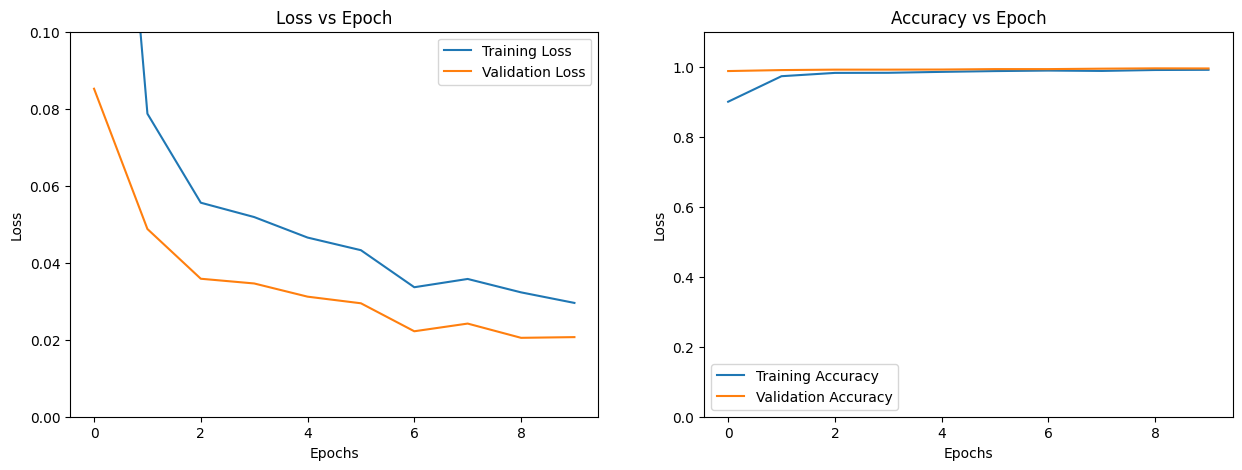

In [31]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15,5))
ax[0].plot(loss_train_plot,label="Training Loss")
ax[0].plot(loss_val_plot,label="Validation Loss")
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,0.1])
ax[0].set_title("Loss vs Epoch")
ax[0].legend()

ax[1].plot(acc_train_plot,label="Training Accuracy")
ax[1].plot(acc_val_plot,label="Validation Accuracy")
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_ylim([0,1.1])
ax[1].set_title("Accuracy vs Epoch")
ax[1].legend()

plt.show()

## Model Testing

In [32]:
test_dir = '/kaggle/input/test-audios/audio_test'

In [33]:
audios = os.listdir(test_dir)
model.eval()
with torch.no_grad():
    for audio_pth in audios:
        signal,sr = torchaudio.load(os.path.join(test_dir,audio_pth))
        signal = signal.to(device)
        signal = audio_preprocessing(signal,sr,mel_spectrogram,device)
        signal = signal.unsqueeze(0)
        pred = model(signal)
        pred_label = torch.sigmoid(pred)
        pred_label = (pred_label > 0.5).int()
        print(audio_pth)
        if pred_label == 1:
            print('female')
        else:
            print('male')
        

female1.mp3
female
female2.mp3
female
male2.mp3
male
male1.mp3
female
female3.mp3
female


In [27]:
# after training
torch.save(model.state_dict(), "model_weights.pth")